## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from skimage import io
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC, FalsePositives, FalseNegatives, TrueNegatives, TruePositives
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['Image Path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image Path
39886,00010426_000.png,No Finding,0,10426,58,M,PA,2690,2745,0.143,0.143,NaN,/data/images_005/images/00010426_000.png
32945,00008626_013.png,Infiltration,13,8626,37,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008626_013.png
104848,00028108_000.png,No Finding,0,28108,25,F,PA,3056,2544,0.139,0.139,NaN,/data/images_011/images/00028108_000.png
86120,00021233_000.png,No Finding,0,21233,42,M,PA,2682,2650,0.143,0.143,NaN,/data/images_010/images/00021233_000.png
20238,00005403_015.png,No Finding,15,5403,35,F,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00005403_015.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Nothing interesting in column 'Unnamed: 11', so we drop it
all_xray_df = all_xray_df.drop('Unnamed: 11', axis=1)

# Get all possible labels and leave them in a list
all_labels = list(np.unique(list(chain(*all_xray_df['Finding Labels'].map(
    lambda x: x.split('|')).tolist()))))

# Now I create a new column in the dataframe for each disease. In each of these
# new columns I will assign a 1 if the disease is present in the "Finding Labels"
# field, and a 0 otherwise.
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(
        lambda finding: 1.0 if c_label in finding else 0)

In [4]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda df: '1' if df['Pneumonia']==1.0 else '0', axis=1)

## Create your training and testing data:

In [6]:
def create_splits(df, verbose=False):

    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia

    # Proportion of validation cases over the entire dataset
    prop_val = 0.2
    
    # Get initial datasets
    train_df, valid_df = skl.train_test_split(df,
                                              test_size=prop_val,
                                              stratify=df['pneumonia_class'])

    #################
    # Train dataset
    #################

    # We select two groups in the train dataframe, depending on the value of 'pneumonia_class'
    pneu_tr_idx = train_df[train_df.pneumonia_class=='1'].index.tolist()
    npneu_tr_idx = train_df[train_df.pneumonia_class=='0'].index.tolist()

    # Get a random sample of non-pneumonia cases with length equal to the length
    # of the pneumonia group
    npneu_tr_idx = sample(npneu_tr_idx, len(pneu_tr_idx))

    # And leave all together in the dataframe
    train_df = train_df.loc[pneu_tr_idx + npneu_tr_idx]

    # Info messages
    if verbose:
        print('Number of pneumonia samples in train dataset: {}'.format(len(pneu_tr_idx)))
        print('Number of non-pneumonia samples in train dataset: {}'.format(len(npneu_tr_idx)))

    #####################
    # Validation dataset
    #####################

    # Proportion of pneumonia in validation dataset
    prop_pneu_vd = 0.2

    # We select two groups in the validation dataframe, depending on the value of pneumonia_class
    pneu_vd_idx = valid_df[valid_df.pneumonia_class=='1'].index.tolist()
    npneu_vd_idx = valid_df[valid_df.pneumonia_class=='0'].index.tolist()
    
    # Get a sample of non-pneumonia with a length equal to the corresponding one to obtain
    # the desired proportion.
    n_pneu_vd = len(pneu_vd_idx)  # Number of items with pneumonia

    # Number of items of non-pneumonia validation dataset
    n_npneu_vd = int(n_pneu_vd / prop_pneu_vd) - n_pneu_vd
    
    # Get a sample of that lenght
    npneu_vd_idx = sample(npneu_vd_idx, n_npneu_vd)

    # And leave all together in the dataframe
    valid_df = valid_df.loc[pneu_vd_idx + npneu_vd_idx]

    # Info messages
    if verbose:
        print('Number of pneumonia samples in validation dataset: {}'.format(n_pneu_vd))
        print('Number of non-pneumonia samples in validation dataset: {}'.format(n_npneu_vd))

    return train_df, valid_df

In [7]:
# Split datasets using the function above
train_df, valid_df = create_splits(all_xray_df, verbose=True)

Number of pneumonia samples in train dataset: 1145
Number of non-pneumonia samples in train dataset: 1145
Number of pneumonia samples in validation dataset: 286
Number of non-pneumonia samples in validation dataset: 1144


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [9]:
def my_image_augmentation(**kwargs):

    # Manage keyword arguments
    mode = kwargs['mode'] if 'mode' in kwargs else 'train'
    rescale = kwargs['rescale'] if 'rescale' in kwargs else (1.0 / 255.0)
    h_flip = kwargs['horizontal_flip'] if 'horizontal_flip' in kwargs else True
    v_flip = kwargs['vertical_flip'] if 'vertical_flip' in kwargs else False
    h_shift = kwargs['height_shift'] if 'height_shift' in kwargs else 0.1
    w_shift = kwargs['width_shift'] if 'width_shift' in kwargs else 0.1
    rotation = kwargs['rotation'] if 'rotation' in kwargs else 15
    shear = vargs['shear'] if 'shear' in kwargs else 0.1
    zoom = vargs['zoom'] if 'rotation' in kwargs else 0.1
    
    # Augmentation for training
    if mode == 'train':
        idg = ImageDataGenerator(rescale=rescale,
                                 horizontal_flip=h_flip,
                                 vertical_flip=v_flip,
                                 height_shift_range=h_shift,
                                 width_shift_range=w_shift,
                                 rotation_range=rotation,
                                 shear_range=shear,
                                 zoom_range=zoom #,
                                 # featurewise_center=True,
                                 # featurewise_std_normalization=True
                                )
    else:
        # Rescale for validation
        idg = ImageDataGenerator(rescale=rescale #,
                                 # featurewise_center=True,
                                 # featurewise_std_normalization=True
                                )
    
    return idg


def make_train_gen(**kwargs):

    # Manage keyword arguments
    df = kwargs['dataframe'] if 'dataframe' in kwargs else None
    directory = kwargs['directory'] if 'directory' in kwargs else None
    x_col = kwargs['x_col'] if 'x_col' in kwargs else 'Image Path'
    y_col = kwargs['y_col'] if 'y_col' in kwargs else 'pneumonia_class'
    class_mode = kwargs['class_mode'] if 'class_mode' in kwargs else 'binary'
    target_size = kwargs['target_size'] if 'target_size' in kwargs else IMG_SIZE
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else BATCH_SIZE

    kwargs['mode'] = 'train'
    aug = my_image_augmentation(**kwargs)
    
    # Training generator
    tr_gen = aug.flow_from_dataframe(dataframe=df,
                                     directory=directory,
                                     x_col=x_col,
                                     y_col=y_col,
                                     class_mode=class_mode,
                                     target_size=target_size,
                                     batch_size=batch_size)
    
    return tr_gen


def make_valid_gen(**kwargs):

    # Manage keyword arguments
    df = kwargs['dataframe'] if 'dataframe' in kwargs else None
    directory = kwargs['directory'] if 'directory' in kwargs else None
    x_col = kwargs['x_col'] if 'x_col' in kwargs else 'Image Path'
    y_col = kwargs['y_col'] if 'y_col' in kwargs else 'pneumonia_class'
    class_mode = kwargs['class_mode'] if 'class_mode' in kwargs else 'binary'
    target_size = kwargs['target_size'] if 'target_size' in kwargs else IMG_SIZE
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else BATCH_SIZE

    kwargs['mode'] = 'valid'
    aug = my_image_augmentation(**kwargs)
    
    # Validation generator
    vd_gen = aug.flow_from_dataframe(dataframe=df,
                                     directory=directory,
                                     x_col=x_col,
                                     y_col=y_col,
                                     class_mode=class_mode,
                                     target_size=target_size,
                                     batch_size=batch_size)
    
    return vd_gen

In [10]:
# Built train and validation generators
train_gen = make_train_gen(dataframe=train_df)
valid_gen = make_valid_gen(dataframe=valid_df, batch_size=1024)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

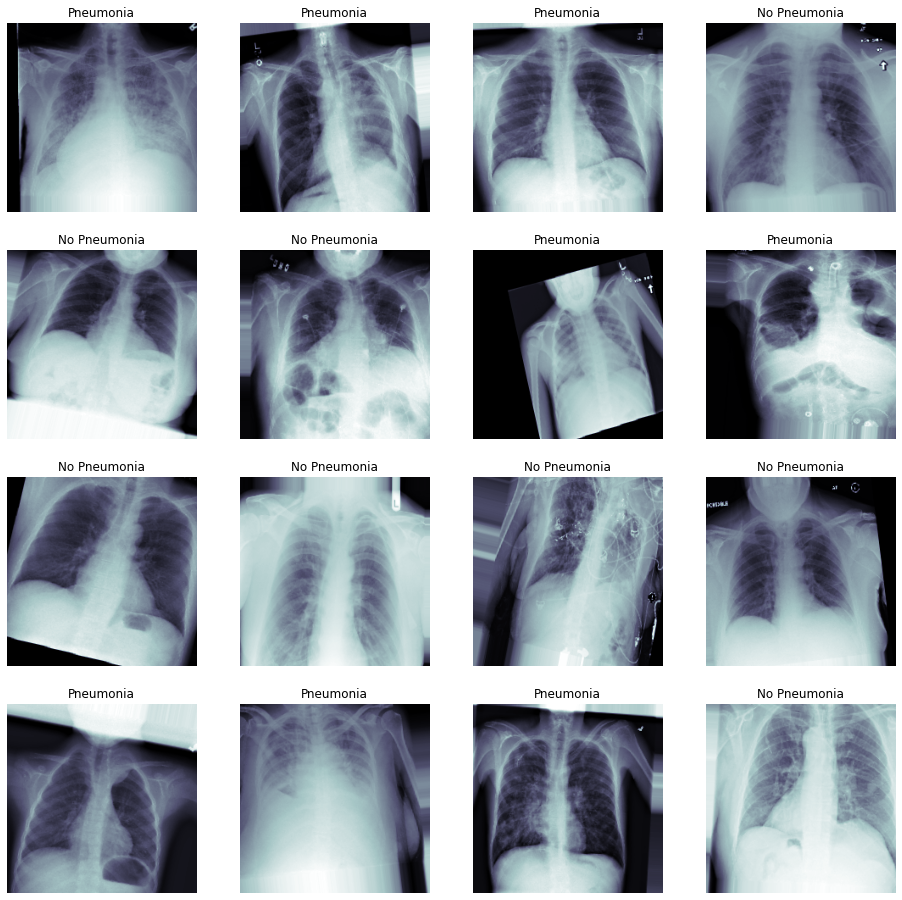

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model(**kwargs):
    
    # Manage keyword arguments
    tr_layer = kwargs['transfer_layer'] if 'transfer_layer' in kwargs else 'block5_pool'
    first_trainable = kwargs['first_trainable'] if 'first_trainable' in kwargs else 17
    verbose = kwargs['verbose'] if 'verbose' in kwargs else False
    
    # Load model VGG16 and build model
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(tr_layer)
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    # Define trainable layers
    for layer in vgg_model.layers[0:first_trainable]:
        layer.trainable = False
    
    # Info
    if verbose:
        print('Model: VGG16')
        for layer in vgg_model.layers:
            print(layer.name, layer.trainable)
    
    return vgg_model


In [14]:
def build_my_model(**kwargs):
    
    # Load pretrained model
    vgg_model = load_pretrained_model(**kwargs)
    
    # Define new model
    model = Sequential()
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate= 0.3))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(rate = 0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [15]:
# Build model
my_model = build_my_model()
my_model.summary()

553467904/553467096 [==============================] - 15s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
____________________________________________________

In [16]:
# Optimizer, loss and metrics
lr = 0.0001
optimizer = Adam(lr=lr) 
loss = 'binary_crossentropy'
metrics=['binary_accuracy', AUC(), FalsePositives(), FalseNegatives(), TrueNegatives(), TruePositives()]
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
# Callbacks

# Name and monitored metric
weight_path = "{}_my_model.best.hdf5".format('xray_class')
monitored_metric = 'val_loss'

# Callbacks

# Checkpoint
checkpoint = ModelCheckpoint(weight_path,
                             monitor=monitored_metric,
                             verbose=1,
                             save_best_only=True,
                             mode='min', 
                             save_weights_only=True)

# Early stopping
early = EarlyStopping(monitor=monitored_metric,
                      mode='min',
                      patience=12)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              cooldown=1)

callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [18]:
## train your model

n_epochs = 40

history = my_model.fit_generator(train_gen,
                                 validation_data=(valX, valY),
                                 epochs=n_epochs,
                                 callbacks=callbacks_list)

Epoch 1/40
72/72 [==============================] - 71s 980ms/step - loss: 0.7330 - binary_accuracy: 0.5284 - auc_1: 0.5385 - false_positives_1: 547.0000 - false_negatives_1: 533.0000 - true_negatives_1: 598.0000 - true_positives_1: 612.0000 - val_loss: 0.7476 - val_binary_accuracy: 0.4199 - val_auc_1: 0.6341 - val_false_positives_1: 555.0000 - val_false_negatives_1: 39.0000 - val_true_negatives_1: 253.0000 - val_true_positives_1: 177.0000

Epoch 00001: val_loss improved from inf to 0.74757, saving model to xray_class_my_model.best.hdf5
Epoch 2/40
72/72 [==============================] - 58s 805ms/step - loss: 0.6894 - binary_accuracy: 0.5585 - auc_1: 0.5840 - false_positives_1: 568.0000 - false_negatives_1: 443.0000 - true_negatives_1: 577.0000 - true_positives_1: 702.0000 - val_loss: 0.5992 - val_binary_accuracy: 0.7129 - val_auc_1: 0.6461 - val_false_positives_1: 161.0000 - val_false_negatives_1: 133.0000 - val_true_negatives_1: 647.0000 - val_true_positives_1: 83.0000

Epoch 00002:

In [ ]:
# Check values of mean and std used for normalizing
# print('Data Generator mean=%.3f, std=%.3f' % (history.mean, history.std))

In [19]:
hist_obj = history.history

In [20]:
# Save history
np.save('history.npy', hist_obj)

In [21]:
# Load history
hist_obj = np.load('history.npy', allow_pickle='TRUE').item()

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose=True)

1024/1024 [==============================] - 9s 9ms/step


In [23]:
def plot_auc(t_y, p_y):
    plt.style.use("ggplot")
    fig, c_ax = plt.subplots(1, 1, figsize = (12, 6))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s AUC: %0.5f'  % ('', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], 'k--')
    c_ax.legend(loc='lower right')
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.title('ROC curve')


## what other performance statistics do you want to include here besides AUC?

def plot_precision_recall_curve(test_y, pred_y):
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Precision and Recall curves')
    precision, recall, thresholds = precision_recall_curve(test_y, pred_y)
    ax1.plot(recall, precision, label = '%s Average Precision Score: %0.5f'  % ('',
        average_precision_score(test_y, pred_y)))
    ax1.set_title("Precision-Recall curve")
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')

    ax2.plot(thresholds, precision[:-1], color='blue', label='Precision')
    ax2.plot(thresholds, recall[:-1], color='red', label='Recall')
    ax2.set_title("Precision-Recall by thresholds")
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('P-R value')

def calc_f1(prec, recall):
    num = 2 * (prec*recall)
    den = prec+recall
    den = np.where(den == 0, 1e-9, den)
    return num / den


def f1_threshold_curve(test_y, pred_y):
    precision, recall, thresholds = precision_recall_curve(test_y, pred_y)
    f1_array = calc_f1(precision, recall)
    fig = plt.figure(figsize =(12, 6))
    plt.plot(thresholds, f1_array[:-1])
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.xlabel('Thresholds')
    plt.ylabel('F1-score')
    plt.title('F1-score curve vs thresholds')
    plt.show()
    return f1_array, thresholds

    
#Also consider plotting the history of your model training:

def plot_history(history, patience=0):
    N = len(history["binary_accuracy"])
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training and Validation Accuracy and Losses')
    ax1.plot(np.arange(1, N-patience+1), history["binary_accuracy"][:N-patience], label="train")
    ax1.plot(np.arange(1, N-patience+1), history["val_binary_accuracy"][:N-patience], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax2.plot(np.arange(1, N-patience+1), history["loss"][:N-patience], label="train")
    ax2.plot(np.arange(1, N-patience+1), history["val_loss"][:N-patience], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    plt.show()

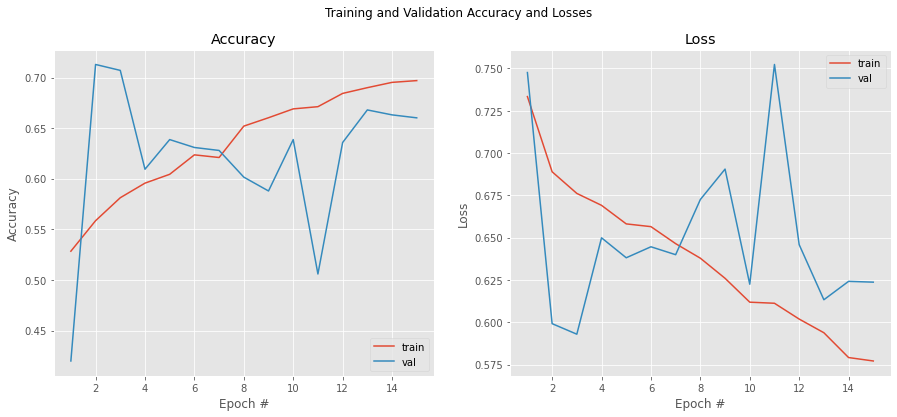

In [24]:
# History
plot_history(hist_obj)

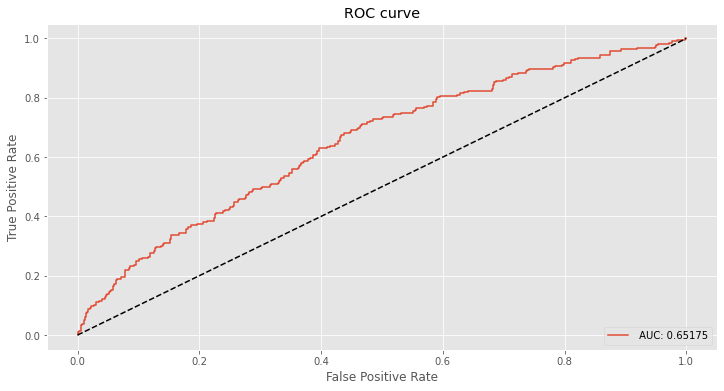

In [25]:
# ROC curve and AUC
plot_auc(valY, pred_Y)

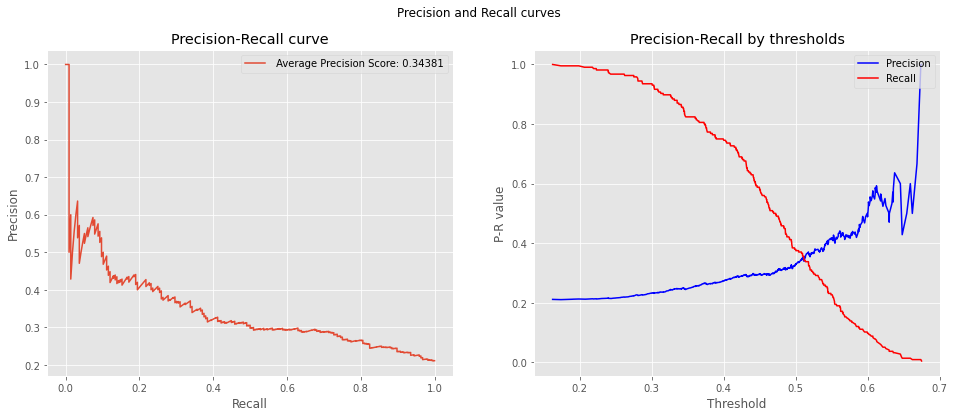

In [26]:
# Precision-recall curve
plot_precision_recall_curve(valY, pred_Y)

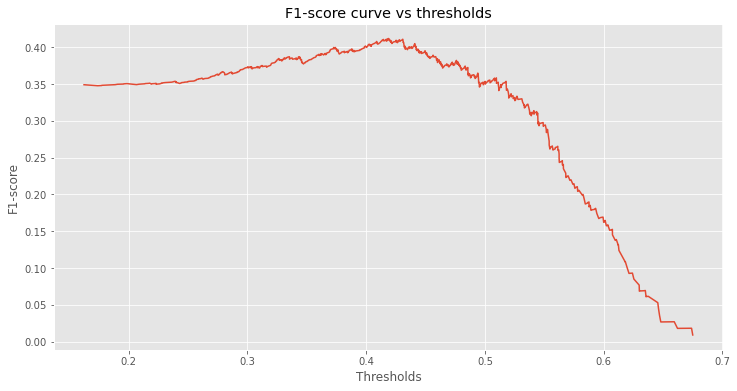

In [27]:
f1s, thresholds = f1_threshold_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In this case we are interested in having reliability in both positive and negative results. However, if one of them had to be emphasized more, it would probably be best to give more confidence to the negative results. Keep in mind that the application is not to confirm a positive diagnosis, since that is the task of the radiologist, but rather to help him prioritize. In this way, I consider that it is better and easier for the radiologist to discard a false positive, than not to stop checking or to overlook a false negative. Therefore, starting from the value that maximizes F1, we will move the threshold slightly lower as long as there is not a very relevant loss of precision.

Threshold that maximizes F1: 0.419


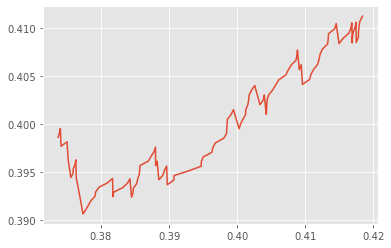

In [29]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
ix = np.argmax(f1s)
print('Threshold that maximizes F1: {:.3f}'.format(thresholds[ix]))

rg = 120
plt.plot(thresholds[ix-rg:ix], f1s[ix-rg:ix])

Finally, instead of selecting 0.419 as the optimal threshold (the maximum of F1) I select 0.374, because this way the recall is favored without penalizing precision too much. 0.374 is the first peak that can be seen in the figure above.

In [30]:
# Map the index of thresholds with the values of thresholds and the F1 peak.
# Look at the third value of the first row. There is the peak.
print(thresholds[ix-rg:ix-rg+12])
print(f1s[ix-rg:ix-rg+12])

[0.37370098 0.3738932  0.37401825 0.3741246  0.37500876 0.37516686
 0.37556255 0.37590027 0.3759201  0.37618816 0.37629253 0.376361  ]
[0.39861751 0.39907728 0.39953811 0.39768786 0.39814815 0.396292
 0.39443155 0.39488966 0.39534884 0.39580908 0.3962704  0.39439907]


In [31]:
thresh = 0.374

In [32]:
# Check precision and recall with this threshold
tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > thresh).astype(int)).ravel()
tn, fp, fn, tp
print('Precision = {:.3f}'.format(tp / (tp + fp)))
print('Recall = {:.3f}'.format(tp / (tp + fn)))

Precision = 0.266
Recall = 0.801


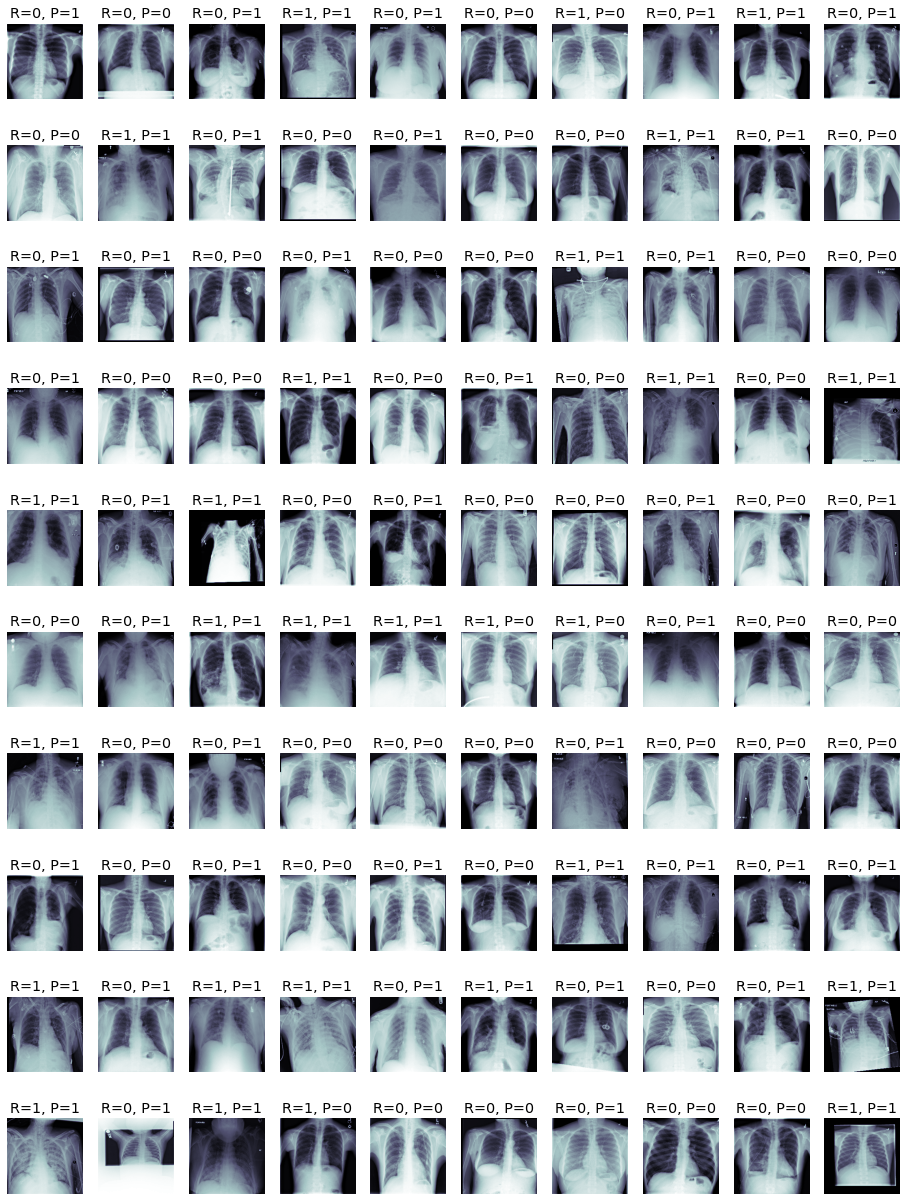

In [33]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 22))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresh:
            c_ax.set_title('R=1, P=1')
        else:
            c_ax.set_title('R=1, P=0')
    else:
        if pred_Y[i] > thresh: 
            c_ax.set_title('R=0, P=1')
        else:
            c_ax.set_title('R=0, P=0')
    c_ax.axis('off')
    i=i+1

In [34]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

Summary:

The precision isn't good enough, but the recall is reasonably good. As mentioned before, this should be use only as an assistance of the radiologist for prioritize.

As a future work, the training could be improved by modifying the hiperparameters, or adding more dense layer to the classifier, or even using a pretreatment of the images.